# Analysing Job Postings #

## Introduction ##

In this project, I will be undertaking an analysis of ~3,000 job listings obtained via web-scraping from a Singapore government job portal. 



In [ ]:
import json 
import re
import numpy as np
import datetime
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [98]:
files=['./data/jobs_{}.csv'.format(i) for i in range(1,6)]
df=pd.concat([pd.read_csv(file) for file in files])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4416 entries, 0 to 418
Data columns (total 13 columns):
company_location    3379 non-null object
company_name        4416 non-null object
date_expiry         4416 non-null object
date_posted         4416 non-null object
employment_type     4416 non-null object
job_description     4416 non-null object
job_requirements    4233 non-null object
job_title           4416 non-null object
num_apps            4416 non-null float64
salary_lower        3912 non-null float64
salary_type         3912 non-null object
salary_upper        3912 non-null float64
seniority           4334 non-null object
dtypes: float64(3), object(10)
memory usage: 483.0+ KB


In [100]:
df.shape

(4416, 13)

In [101]:
salary=df[df['salary_upper'].notna()]
salary.reset_index(inplace=True)
salary['salary_']=(salary.salary_upper + salary.salary_lower)/2

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 15 columns):
index               3912 non-null int64
company_location    3046 non-null object
company_name        3912 non-null object
date_expiry         3912 non-null object
date_posted         3912 non-null object
employment_type     3912 non-null object
job_description     3912 non-null object
job_requirements    3828 non-null object
job_title           3912 non-null object
num_apps            3912 non-null float64
salary_lower        3912 non-null float64
salary_type         3912 non-null object
salary_upper        3912 non-null float64
seniority           3900 non-null object
salary_             3912 non-null float64
dtypes: float64(4), int64(1), object(10)
memory usage: 458.5+ KB


In [103]:
salary['salary_type'].value_counts()

Monthly     3797
Annually     115
Name: salary_type, dtype: int64

In [104]:
salary['salary']=salary.apply(lambda x: x['salary_']/12 if x['salary_type']=='Annually' else x['salary_'],axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
salary=salary[salary['salary']<30000]
salary.reset_index(inplace=True)

In [106]:
salary['seniority'].fillna('',inplace=True)
seniority_cat=salary['seniority'].str.get_dummies(sep=', ')
salary['employment_type'].fillna('',inplace=True)
etype_cat=salary['employment_type'].str.get_dummies(sep=', ')

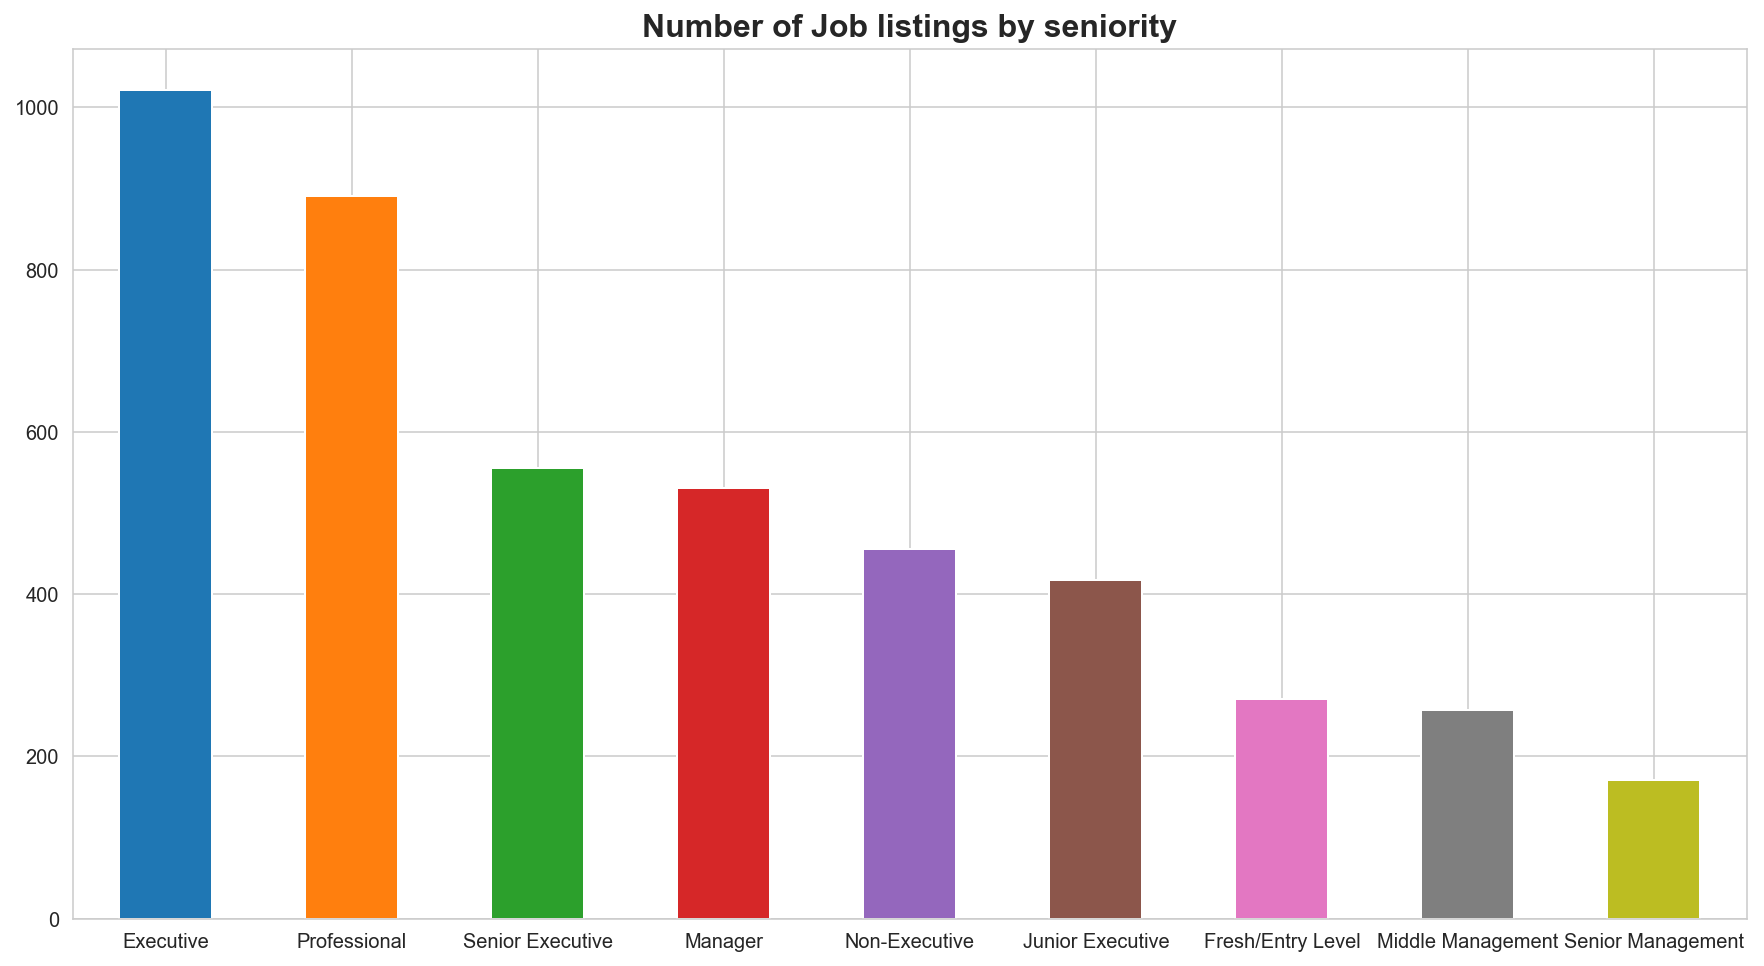

In [107]:
plt.figure(figsize=(15,8))
ax=seniority_cat.apply(sum).sort_values(ascending=False).plot.bar()
labels=ax.get_xticklabels()
ax.set_xticklabels(labels,rotation=0)
ax.set_title('Number of Job listings by seniority',fontsize=16,fontweight='bold')
plt.show()

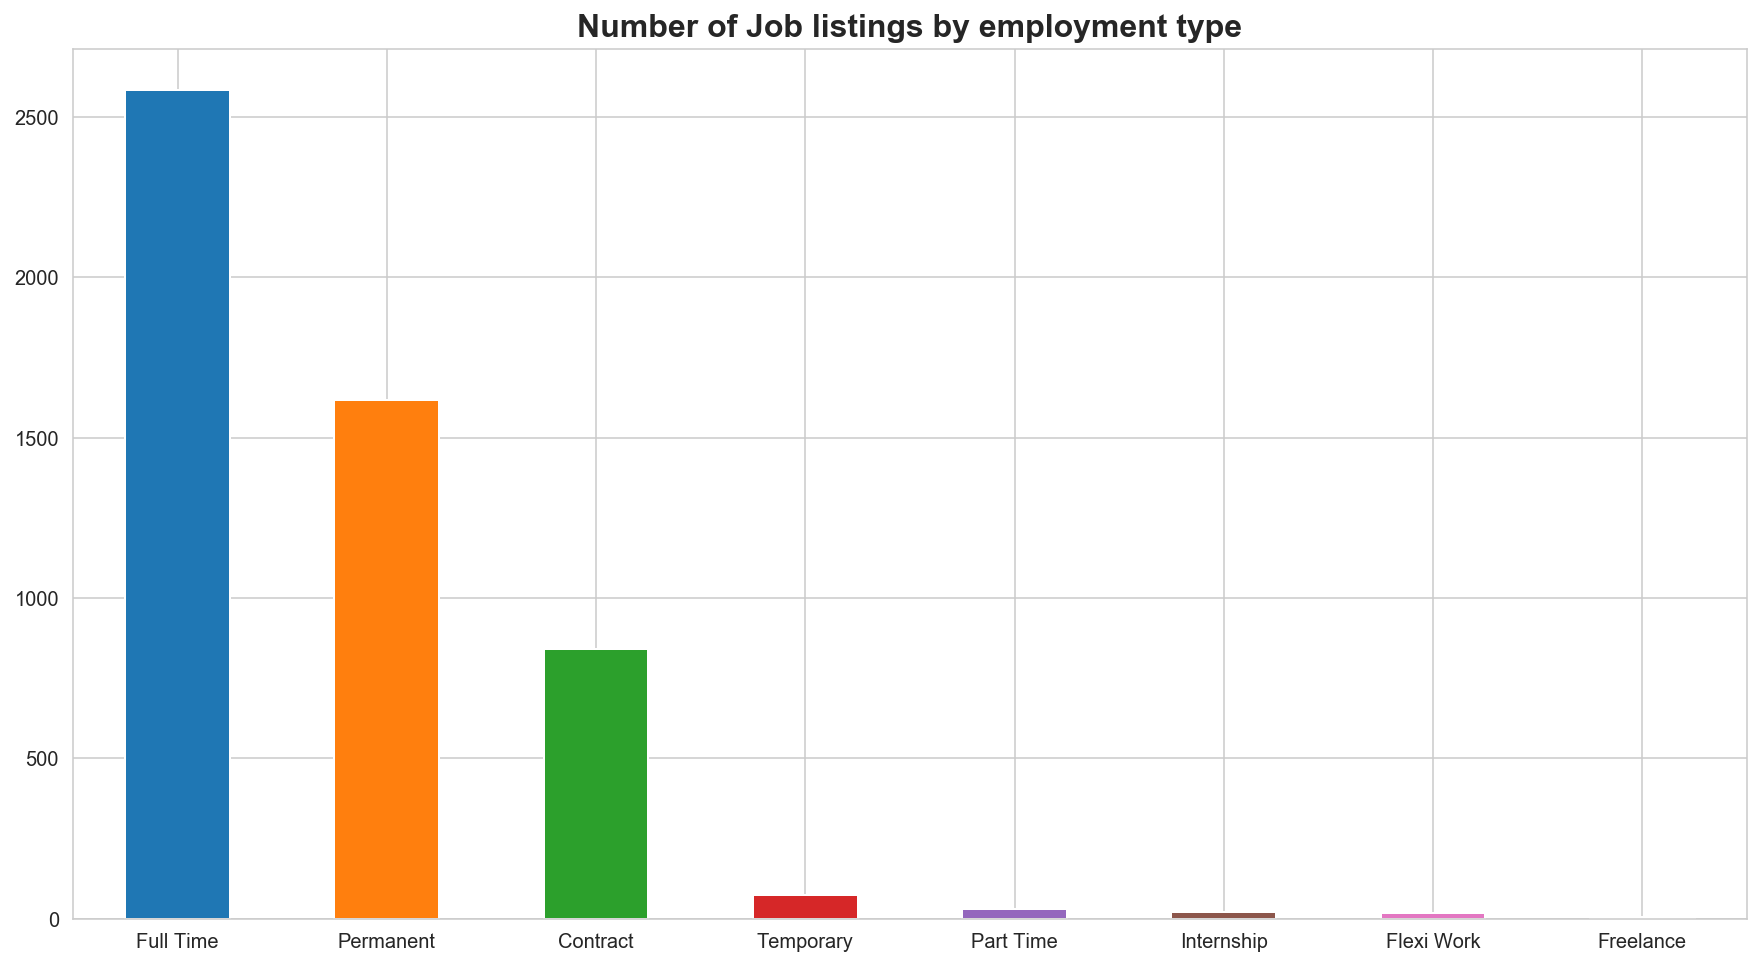

In [108]:
plt.figure(figsize=(15,8))
ax=etype_cat.apply(sum).sort_values(ascending=False).plot.bar()
labels=ax.get_xticklabels()
ax.set_xticklabels(labels,rotation=0)
ax.set_title('Number of Job listings by employment type',fontsize=16,fontweight='bold')
plt.show()

In [109]:
salary=pd.concat([salary,seniority_cat,etype_cat],axis=1)

In [110]:
salary['date_expiry']=salary['date_expiry'].apply(lambda x: datetime.datetime.strptime(x,"%d %b %Y"))
salary['date_posted']=salary['date_posted'].apply(lambda x: datetime.datetime.strptime(x,"%d %b %Y"))
salary['num_day_apply']=salary['date_expiry']-salary['date_posted']
salary['num_day_apply']=salary['num_day_apply'].apply(lambda x: x.days)

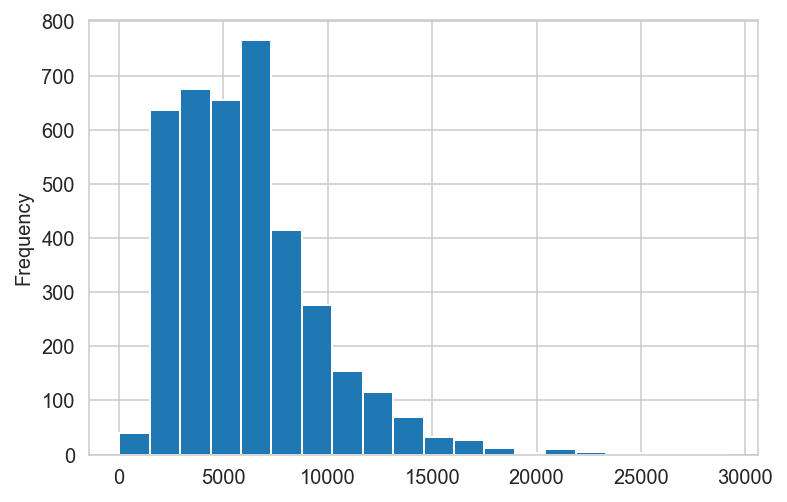

In [226]:
salary['salary'].plot.hist(bins=20)
y=salary['salary']>salary['salary'].quantile(0.75)
y=y.astype(int)
# y=pd.qcut(salary['salary'],q=2,labels=False)

In [112]:
salary['job_description']=salary['job_description'].apply(lambda x : re.sub(r'roles & responsibilities', '', x.lower()) if x is not np.nan else '')
salary['job_requirements']=salary['job_requirements'].apply(lambda x : re.sub(r'requirements.*?(?=\s)', '', x.lower()) if x is not np.nan else '')

In [424]:
job_cat=salary[['Executive', 'Fresh/Entry Level',
       'Junior Executive', 'Manager', 'Middle Management', 'Non-Executive',
       'Professional', 'Senior Executive', 'Senior Management', 'Contract',
       'Flexi Work', 'Freelance', 'Full Time', 'Internship', 'Part Time',
       'Permanent', 'Temporary']]

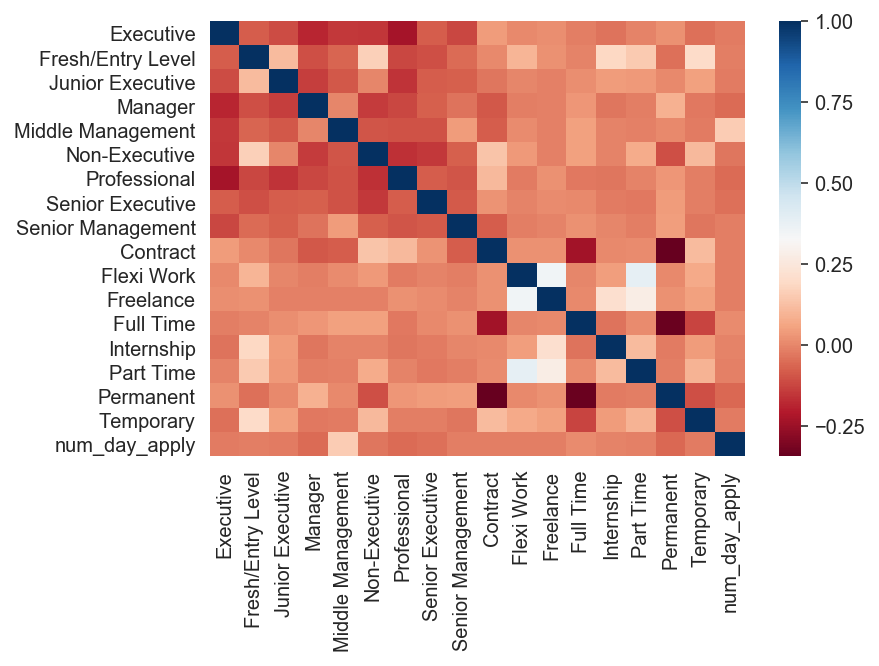

In [115]:
sns.heatmap(job_cat.corr(),cmap='RdBu')

In [268]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [421]:
salary['num_apps_scaled']=StandardScaler().fit_transform(salary['num_apps'].values.reshape(-1,1))
salary['num_day_apply_scaled']=StandardScaler().fit_transform(salary['num_day_apply'].values.reshape(-1,1))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [422]:
sss=StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=120)

for train_index, test_index in sss.split(X1, y):
    salary_train,salary_test= salary.iloc[train_index], salary.iloc[test_index]
    y_train,y_test= y.iloc[train_index].values, y.iloc[test_index].values
    

In [355]:

class BestNLP:
    
    def __init__(self,stop_words,max_features,ngram_range, min_df):
        self.stop_words=stop_words
        self.min_df=min_df
        self.max_features=max_features
        self.ngram_range=ngram_range
        
    
    def init_vectorizers(self):
        cvect=CountVectorizer(stop_words=self.stop_words,max_features=self.max_features,ngram_range=self.ngram_range,min_df=2)
        tfidf=TfidfVectorizer(stop_words=self.stop_words,min_df=self.min_df,max_features=self.max_features)
        return [('BOW',cvect),('TF-IDF',tfidf)]
    
    def cross_val_class(self,model,name,X,y,scoring=None,folds=5,verbose=True):

        # Compute cross val score # 

        scores = cross_val_score(model, X, y, cv=folds,scoring=scoring)
        
        if verbose:
            print( '------------------------------------\n')
            print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)

            if scoring==None:
                print('Performance Metric: Accuracy')
            else:
                print('Performance Metric: '+scoring)

            print("Cross-validated scores:", scores)
            print("Mean score:", np.mean(scores))
            print('Std score:', np.std(scores))
        
        return np.mean(scores)

        
    def fitCV(self,models,X,y,scoring=None,n_folds=5):
        
        scores=[]
        estimators=[]
        names=[]
        vectorizers_=[]
        sparse_Xs=[]
        
        for model in models:
            vectorizers = self.init_vectorizers()
            
            for vectorizer in vectorizers:

                X_vec=vectorizer[1].fit_transform(X)
                estimator=Pipeline([vectorizer,model])
                estimator.fit(X,y)
                name=vectorizer[0]+'-'+model[0]
                mean_score=self.cross_val_class(estimator,name,X,y,scoring,folds=n_folds)
                vectorizers_.append(vectorizer)
                scores.append(mean_score)
                estimators.append(estimator)
                names.append(name)
                sparse_Xs.append(X_vec)
        
        best_ind=scores.index(max(scores))
        self.vect=vectorizers_[best_ind]
        self.best_estimator=estimators[best_ind]
        self.X_=sparse_Xs[best_ind]
        self.estimator_CVscores=dict(zip(names,scores))
    

In [356]:


## Generate features  ## 
stopwords = list(stop_words.ENGLISH_STOP_WORDS)
stopwords+= ['requirements','minimum','qualifications','enhance','email']


nb= BernoulliNB()
lr=LogisticRegression(max_iter=500,solver='lbfgs')
svc=LinearSVC(max_iter=3000)
models=[('Naive-Bayes',nb),('Logistic Regression',lr),('Linear SVC',svc)]

In [357]:
nlp_JD=BestNLP(stop_words=stopwords,max_features=1000,ngram_range=(1,2),min_df=2)

nlp_JD.fitCV(models,salary_train['job_description'],y_train,scoring='roc_auc')

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.77900676 0.75631799 0.83028576 0.79204178 0.79728365]
Mean score: 0.7909871885261287
Std score: 0.024209994523763958
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.7782647  0.75670302 0.8294737  0.79048766 0.79553682]
Mean score: 0.79009318023416
Std score: 0.023813565422887966
------------------------------------

5-Fold Cross Validated Results for Model: BOW-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.79265083 0.79582907 0.78551027 0.80991417 0.81184757]
Mean score: 0.7991503828824073
Std score: 0.01016273333911161
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.85282752 0.82517536 0.8620

/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anac

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Linear SVC
Performance Metric: roc_auc
Cross-validated scores: [0.74049676 0.75956625 0.75231368 0.7846702  0.77152318]
Mean score: 0.7617140136930681
Std score: 0.015273228105881024
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Linear SVC
Performance Metric: roc_auc
Cross-validated scores: [0.8474931  0.81345645 0.84186467 0.85179144 0.85370131]
Mean score: 0.8416613945040256
Std score: 0.014677510261651733


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


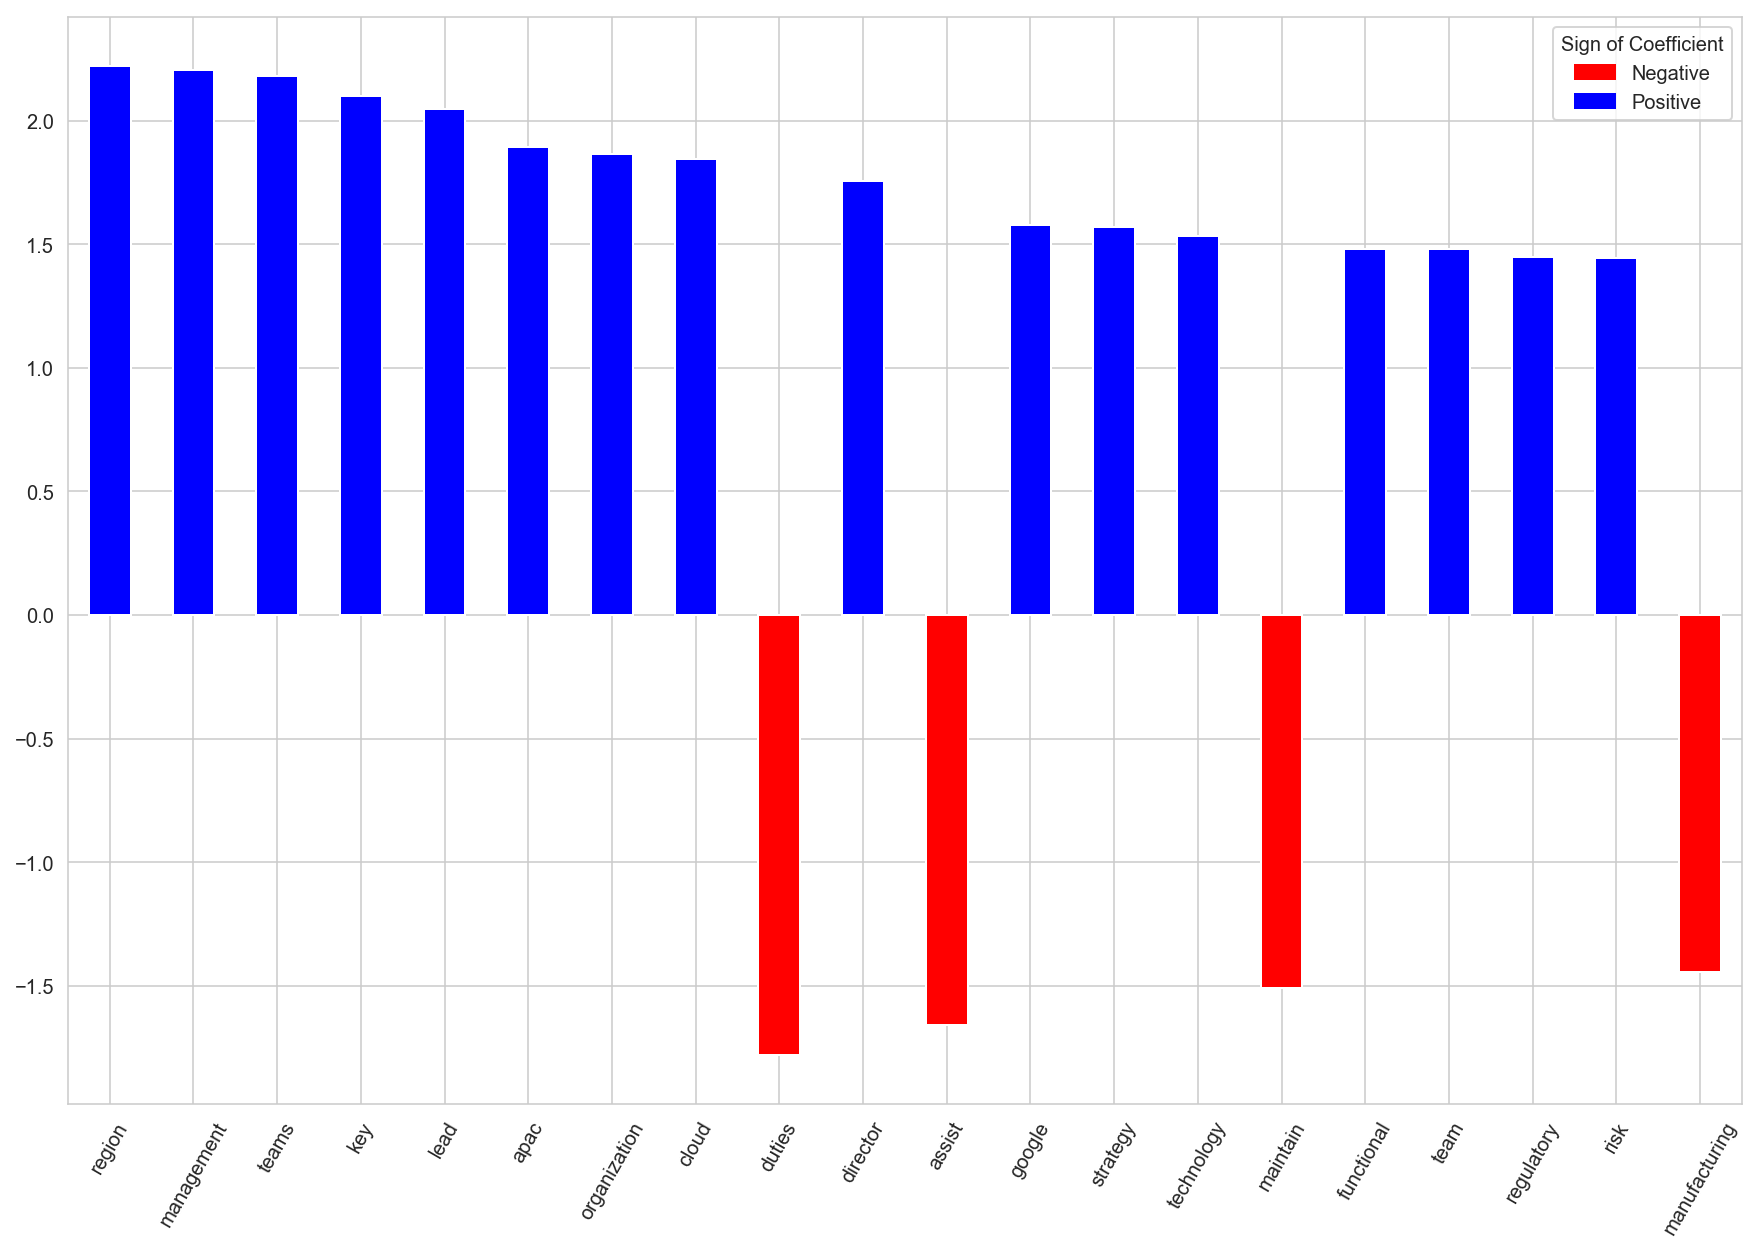

In [407]:
coef= nlp_JD.best_estimator.named_steps['Logistic Regression'].coef_[0]
feat_names=nlp_JD.vect[1].get_feature_names()

lr_coefs=pd.DataFrame({'coefficient':coef, 'feature_names':feat_names,'abs_coef':np.abs(coef)})
lr_coefs.sort_values('abs_coef',inplace=True,ascending=False)
to_plot=lr_coefs.head(20)

to_plot['color']=to_plot['coefficient'].apply(lambda x : 'blue' if x>0 else 'red')


f=to_plot['coefficient'].plot.bar(color=to_plot['color'],figsize=(15,10))
f.set_xticklabels(to_plot['feature_names'],rotation=60)
red_patch = mpatches.Patch(color='red', label='Negative')
blue_patch= mpatches.Patch(color='blue', label='Positive')
f.legend(handles=[red_patch,blue_patch],title='Sign of Coefficient')


In [411]:
JD_model=nlp_JD.best_estimator
JD_model.score(salary_test['job_description'],y_test)

0.8076923076923077

In [414]:
NLP_JR=BestNLP(stop_words=stopwords,max_features=1000,ngram_range=(1,2),min_df=2)
NLP_JR.fitCV(models,salary_train['job_requirements'],y_train,scoring='roc_auc')

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.77363734 0.80662392 0.80941713 0.8410386  0.77035863]
Mean score: 0.8002151244068223
Std score: 0.026038797084137283
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Naive-Bayes
Performance Metric: roc_auc
Cross-validated scores: [0.76758887 0.80100248 0.80017641 0.83760133 0.76029156]
Mean score: 0.7933321311774183
Std score: 0.027639954590648663
------------------------------------

5-Fold Cross Validated Results for Model: BOW-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.78001484 0.77653557 0.82326421 0.82938269 0.79517903]
Mean score: 0.8008752699659725
Std score: 0.021789738695696045
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Logistic Regression
Performance Metric: roc_auc
Cross-validated scores: [0.81871386 0.8372303  0.8

/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anac

------------------------------------

5-Fold Cross Validated Results for Model: BOW-Linear SVC
Performance Metric: roc_auc
Cross-validated scores: [0.73386724 0.71241057 0.77876874 0.7936099  0.75794141]
Mean score: 0.7553195725537778
Std score: 0.029408407389882586
------------------------------------

5-Fold Cross Validated Results for Model: TF-IDF-Linear SVC
Performance Metric: roc_auc
Cross-validated scores: [0.80048444 0.81582263 0.83303698 0.85333856 0.81017791]
Mean score: 0.8225721038444389
Std score: 0.018671501233860074


In [416]:
NLP_JR.best_estimator

Pipeline(memory=None,
     steps=[('TF-IDF', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [417]:
NLP_JR.best_estimator.score(salary_test['job_requirements'],y_test)

0.8243589743589743

In [437]:
print(confusion_matrix(y_test,NLP_JR.best_estimator.predict(salary_test['job_requirements'])))

[[556  35]
 [102  87]]


In [434]:
print(classification_report(y_test,NLP_JR.best_estimator.predict(salary_test['job_requirements'])))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       591
           1       0.71      0.46      0.56       189

   micro avg       0.82      0.82      0.82       780
   macro avg       0.78      0.70      0.72       780
weighted avg       0.81      0.82      0.81       780



/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


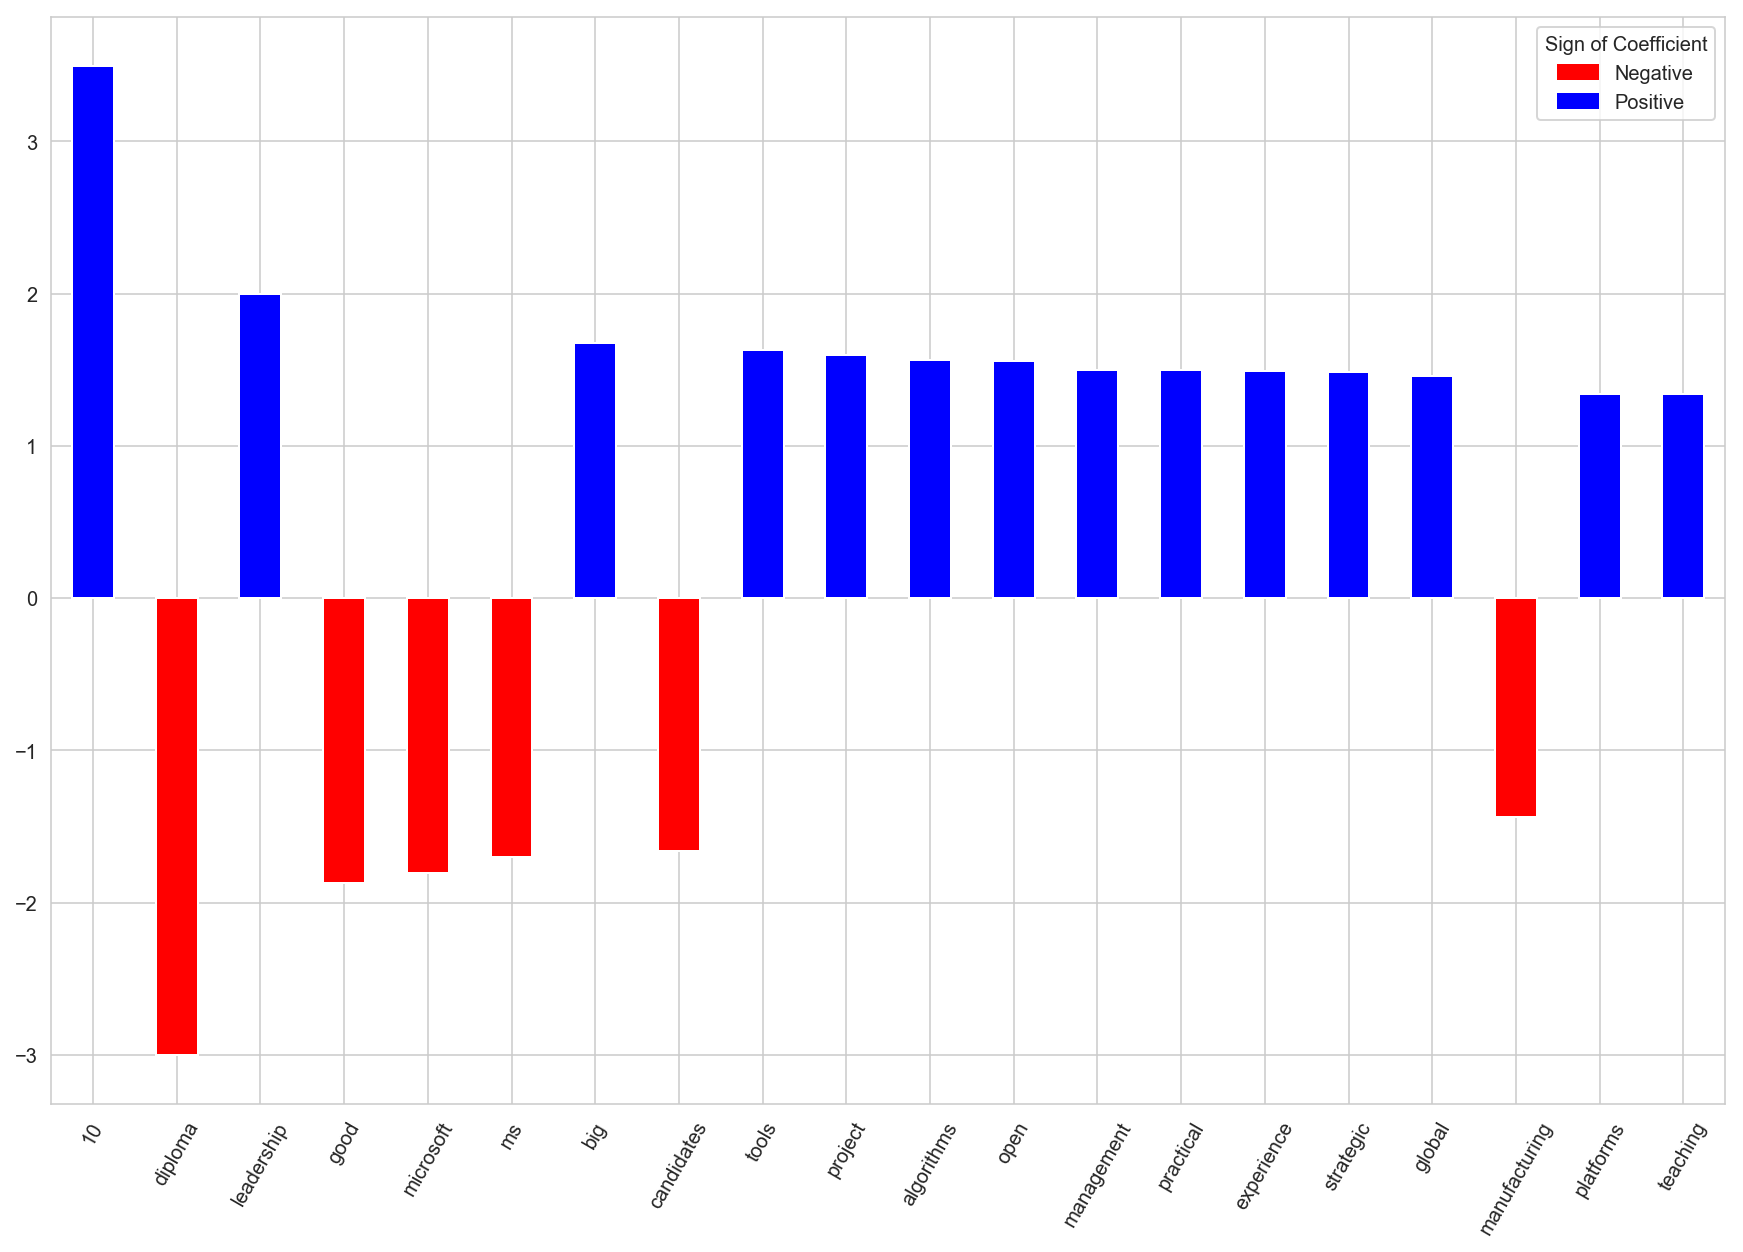

In [415]:
coef= NLP_JR.best_estimator.named_steps['Logistic Regression'].coef_[0]
feat_names=NLP_JR.vect[1].get_feature_names()

lr_coefs=pd.DataFrame({'coefficient':coef, 'feature_names':feat_names,'abs_coef':np.abs(coef)})
lr_coefs.sort_values('abs_coef',inplace=True,ascending=False)
to_plot=lr_coefs.head(20)

to_plot['color']=to_plot['coefficient'].apply(lambda x : 'blue' if x>0 else 'red')


f=to_plot['coefficient'].plot.bar(color=to_plot['color'],figsize=(15,10))
f.set_xticklabels(to_plot['feature_names'],rotation=60)
red_patch = mpatches.Patch(color='red', label='Negative')
blue_patch= mpatches.Patch(color='blue', label='Positive')
f.legend(handles=[red_patch,blue_patch],title='Sign of Coefficient')

In [440]:
### Dense features model ### 

dense_feats=job_cat.columns.tolist() + ['num_day_apply_scaled','num_apps_scaled']
Xd_train=salary_train[dense_feats]
Xd_test=salary_test[dense_feats]

In [441]:
Xd_train.shape

(3119, 19)

In [459]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

In [451]:
rf_clf=RandomForestClassifier()

rfr_params={
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50,100,150,200]}

gs_rf=GridSearchCV(rf_clf,rfr_params,verbose=10,scoring='roc_auc')
gs_rf.fit(Xd_train,y_train)

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 88 candidates, totalling 264 fits
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.7802075779550399, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.8141039199097575, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=50 ................
[CV]  max_depth=10, max_features=auto, n_estimators=50, score=0.8008600117297309, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.7777097937313673, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.8141391708967851, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.7979983618824196, total=   0.1s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.7790921360083796, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.816274373539602, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.8016740146014926, total=   0.2s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.781159354604786, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.8155492103778905, total=   0.3s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.8010976398972637, total=   0.3s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.7767051406010798, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.8189005720731609, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=10, max_features=sqrt, n_estimators=50, score=0.8000915121240925, total=   0.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=100 ............

[CV]  max_depth=30, max_features=auto, n_estimators=200, score=0.7618644750624447, total=   0.3s
[CV] max_depth=30, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=30, max_features=auto, n_estimators=200, score=0.7410434404513924, total=   0.3s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7409732293932801, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7607616227540086, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=30, max_features=sqrt, n_estimators=50, score=0.7325874168301414, total=   0.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=100, score=0.7402027435339619, total=   0.2s
[CV] max_depth=30, max_features=sqrt, n_estimators=100 ...........

[CV]  max_depth=50, max_features=auto, n_estimators=200, score=0.7388946751066799, total=   0.4s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.7353204818306341, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.7559725243735397, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=50, max_features=sqrt, n_estimators=50, score=0.73783040427124, total=   0.1s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=50, max_features=sqrt, n_estimators=100, score=0.7437580573684635, total=   0.2s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=50, max_features=sqrt, n_estimators=100, score=0.7576242849085489, total=   0.2s
[CV] max_depth=50, max_features=sqrt, n_estimators=100 .............

[CV]  max_depth=70, max_features=sqrt, n_estimators=50, score=0.7645964265570864, total=   0.1s
[CV] max_depth=70, max_features=sqrt, n_estimators=50 ................
[CV]  max_depth=70, max_features=sqrt, n_estimators=50, score=0.7424060104758632, total=   0.1s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.7428969261139311, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.7646971436628798, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=100, score=0.7420849596537707, total=   0.2s
[CV] max_depth=70, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=150, score=0.7390218354685361, total=   0.3s
[CV] max_depth=70, max_features=sqrt, n_estimators=150 ..........

[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.7440123680605915, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.7613936225928613, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=100 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=100, score=0.7409423220822295, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7469709330432681, total=   0.2s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7648104504068971, total=   0.3s
[CV] max_depth=90, max_features=sqrt, n_estimators=150 ...............
[CV]  max_depth=90, max_features=sqrt, n_estimators=150, score=0.7429722733431755, total=   0.3s
[CV] max_depth=90, max_features=sqrt, n_estimators=200 ........

[CV]  max_depth=None, max_features=sqrt, n_estimators=100, score=0.7621011602610587, total=   0.2s
[CV] max_depth=None, max_features=sqrt, n_estimators=100 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=100, score=0.7431163670192328, total=   0.2s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.7430505197002659, total=   0.2s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.7640777334622513, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators=150 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=150, score=0.7416273990333084, total=   0.3s
[CV] max_depth=None, max_features=sqrt, n_estimators=200 .............
[CV]  max_depth=None, max_features=sqrt, n_estimators=200, score=0.744614152767706, total=   0.4s
[CV] max_depth=None, max_features=sqrt, n_estimators

[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:  1.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [458]:
rfc=gs_rf.best_estimator_
rfc.fit(Xd_train,y_train)
rfc_preds=rfc.predict(Xd_test)
pd.DataFrame(confusion_matrix(y_test,rfc_preds),columns=['Low Salary','High Salary'],index=['Low Salary','High Salary'])

,Low Salary,High Salary
Low Salary,566,25
High Salary,136,53


In [454]:
rfc.score(Xd_test,y_test)

0.7987179487179488

In [455]:
roc_auc_score(y_test,rfc_preds)

0.6260441006633899

In [460]:
xgb=XGBClassifier()
params={
    'learning_rate':np.linspace(0.3,0.1,num=5),
    'max_depth':[6,7,8,9],
    'gamma':np.linspace(0.1,0.5,num=5),
    'min_child_weight':[1,3,5],
}
xgb_gs=GridSearchCV(xgb,param_grid=params,cv=5,verbose=10)
xgb_gs.fit(Xd_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7612179487179487, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7660256410256411, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7948717948717948, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7576243980738363, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7740384615384616, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.0s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7836538461538461, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.4s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7692307692307693, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.9s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7948717948717948, total=   0.5s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3 ...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.3s remaining:    0.0s


[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7495987158908507, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7612179487179487, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7868589743589743, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7724358974358975, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.8012820512820513, total=   0.4s
[CV] gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7688603531300161, total

[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7660256410256411, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7692307692307693, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7740384615384616, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7964743589743589, total=   0.6s
[CV] gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.3, max_depth=9, min_child_weight=5, score=0.7512038523274478, total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=6, min_child_weight=1, score=0.7612179487179487, tota

[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.780448717948718, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.7692307692307693, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.7948717948717948, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=8, min_child_weight=5, score=0.7624398073836276, total=   0.5s
[CV] gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7612179487179487, total=   0.6s
[CV] gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7596153846153846, 

[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.7708333333333334, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.8060897435897436, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.7768860353130016, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7692307692307693, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7612179487179487, total=   0.5s
[CV] gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=1, score=0.7692307692307693, total

[CV]  gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.8076923076923077, total=   0.4s
[CV] gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.7817014446227929, total=   0.4s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7676282051282052, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7612179487179487, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7724358974358975, total=   0.5s
[CV] gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.7964743589743589,

[CV]  gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7656500802568218, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7708333333333334, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7740384615384616, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7788461538461539, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7900641025641025, total=   0.4s
[CV] gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7849117174959872, tota

[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7612179487179487, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7612179487179487, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7692307692307693, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7836538461538461, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7608346709470305, total=   0.6s
[CV] gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=3, score=0.7724358974358975, total

[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7628205128205128, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7772435897435898, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7900641025641025, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7672552166934189, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3, score=0.7772435897435898, total=   0.5s
[CV] gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=3, score=0.782051282051282, total=

[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7724358974358975, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7948717948717948, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7624398073836276, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7708333333333334, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7660256410256411,

[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7932692307692307, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7736757624398074, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7596153846153846, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7884615384615384, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7708333333333334, total=   0.4s
[CV] gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.8012820512820513, total

[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7576243980738363, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7724358974358975, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7884615384615384, total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7548076923076923, total=   0.6s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7932692307692307, total=   0.5s
[CV] gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7528089887640449, total

[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7692307692307693, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7836538461538461, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7676282051282052, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.8108974358974359, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7656500802568218, total=   0.5s
[CV] gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5 ..
[CV]  gamma=0.2, learning_rate=0.15, max_depth=8, min_child_weight=5, score=0.7628205128205128,

[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7772435897435898, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8012820512820513, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7640449438202247, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=0.7612179487179487, total=   0.5s
[CV] gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=0.7868589743589743, total

[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7788461538461539, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7708333333333334, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.8012820512820513, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7672552166934189, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=6, min_child_weight=5, score=0.7580128205128205, total=   0.4s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7692307692307693, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7724358974358975, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.782051282051282, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7640449438202247, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7724358974358975, total=   0.5s
[CV] gamma=0.30000000000000004, learning

[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.782051282051282, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.7772435897435898, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.8060897435897436, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=7, min_child_weight=5, score=0.7576243980738363, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.25, max_depth=8, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.25, max_depth=8, min_child_weight=1, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.30000000000000004,

[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7660256410256411, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.780448717948718, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.780448717948718, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.8044871794871795, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=6, min_child_weight=3, score=0.7768860353130016, total=   0.5s
[CV] gamma=0.30000000000000004, learning_

[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7692307692307693, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7612179487179487, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7724358974358975, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7932692307692307, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7640449438202247, total=   0.6s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.7640449438202247, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7612179487179487, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7788461538461539, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.15, max_depth=7, min_child_weight=5, score=0.8060897435897436, total=   0.5s
[CV] gamma=0.30000000000000004

[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7916666666666666, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=1, score=0.7849117174959872, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.7628205128205128, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.7788461538461539, total=   0.4s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=6, min_child_weight=3, score=0.782051282051282, total=   0.4s
[CV] gamma=0.30000000000000004, learning

[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.8012820512820513, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7752808988764045, total=   0.5s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7644230769230769, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7740384615384616, total=   0.6s
[CV] gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1 
[CV]  gamma=0.30000000000000004, learning_rate=0.1, max_depth=9, min_child_weight=1, score=0.7724358974358975, total=   0.6s
[CV] gamma=0.30000000000000004, learnin

[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.7836538461538461, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.7772435897435898, total=   0.4s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.8028846153846154, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=7, min_child_weight=5, score=0.7817014446227929, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7692307692307693, total=   0.5s
[CV] gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.3, max_depth=8, min_child_weight=1, score=0.7644230769230769, total

[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.7692307692307693, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.8028846153846154, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=6, min_child_weight=5, score=0.7929373996789727, total=   0.4s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7772435897435898, total=   0.5s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7724358974358975, total=   0.5s
[CV] gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=7, min_child_weight=1, score=0.7724358974358975,

[CV]  gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5, score=0.7964743589743589, total=   0.5s
[CV] gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.4, learning_rate=0.25, max_depth=9, min_child_weight=5, score=0.7720706260032103, total=   0.6s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7740384615384616, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7660256410256411, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7756410256410257, total=   0.4s
[CV] gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=6, min_child_weight=1, score=0.7964743589743589, tot

[CV]  gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5, score=0.7800963081861958, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7628205128205128, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7676282051282052, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7740384615384616, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7836538461538461, total=   0.5s
[CV] gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7592295345104334, total

[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7708333333333334, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7660256410256411, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7756410256410257, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7916666666666666, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, score=0.7800963081861958, total=   0.5s
[CV] gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=3, score=0.7628205128205128,

[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.7644230769230769, total=   0.4s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.782051282051282, total=   0.5s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8044871794871795, total=   0.4s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.7817014446227929, total= 3.9min
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7660256410256411, total=   0.8s
[CV] gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.7772435897435898, total=

[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.7692307692307693, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.8060897435897436, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, score=0.78330658105939, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7612179487179487, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7740384615384616, total=   0.4s
[CV] gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=0.7692307692307693, total= 

[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7916666666666666, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=1, score=0.7592295345104334, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7692307692307693, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7788461538461539, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7756410256410257, total=   0.6s
[CV] gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=3, score=0.7948717948717948, total

[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=1, score=0.7720706260032103, total=15.4min
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7676282051282052, total=   0.7s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7884615384615384, total=   0.6s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7660256410256411, total=   0.6s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.8108974358974359, total=   0.5s
[CV] gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.25, max_depth=8, min_child_weight=3, score=0.7624398073836276,

[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7628205128205128, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7852564102564102, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7740384615384616, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8092948717948718, total=   0.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7656500802568218, total=   0.6s
[CV] gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=0.7580128205128205, total

[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7788461538461539, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7868589743589743, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7964743589743589, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=3, score=0.7849117174959872, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.7596153846153846, total=   0.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=6, min_child_weight=5, score=0.7900641025641025,

[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.7788461538461539, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.7980769230769231, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.7704654895666132, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7596153846153846, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7868589743589743, total=   0.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5 ..
[CV]  gamma=0.5, learning_rate=0.15, max_depth=9, min_child_weight=5, score=0.7836538461538461,

[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3, score=0.8076923076923077, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=3, score=0.7688603531300161, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7580128205128205, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7868589743589743, total=   0.6s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7788461538461539, total=   0.5s
[CV] gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5 ...
[CV]  gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=5, score=0.7996794871794872, total

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 207.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.3 , 0.25, 0.2 , 0.15, 0.1 ]), 'max_depth': [6, 7, 8, 9], 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

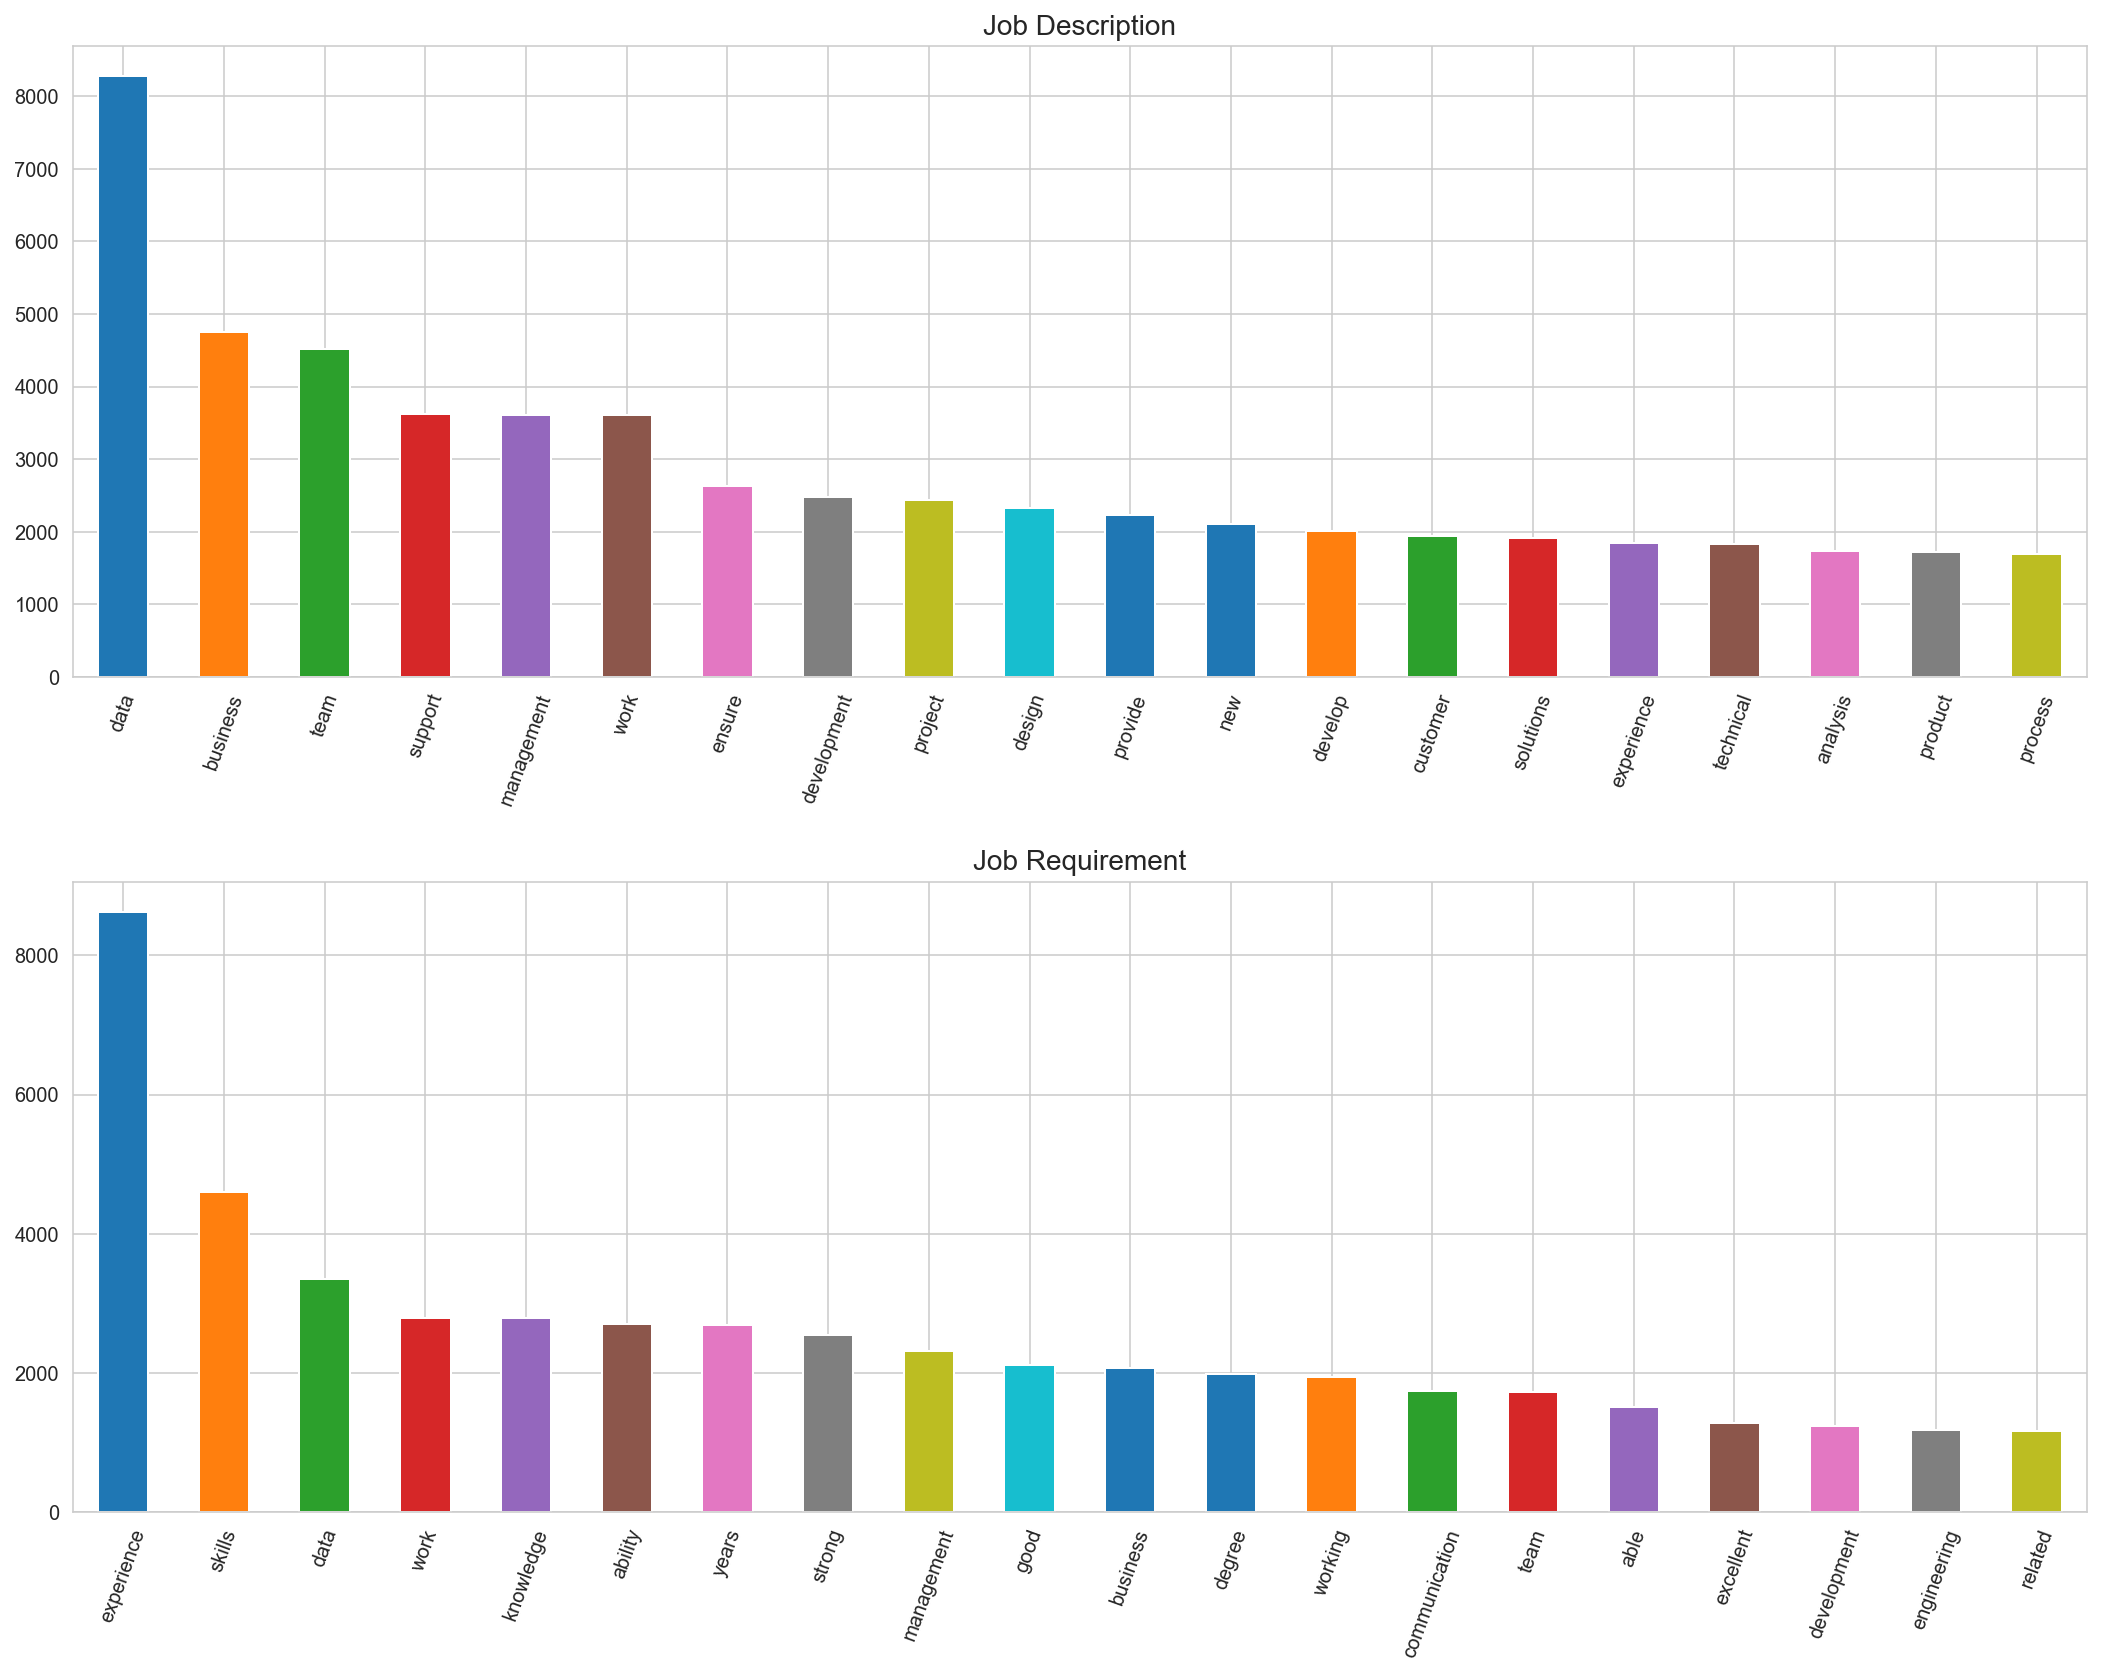

In [161]:
f,ax=plt.subplots(2,1,figsize=(15,12))

pd.DataFrame(X2.todense(),columns=cvec1.get_feature_names()).apply(sum).sort_values(ascending=False).head(20).plot.bar(ax=ax[0])

label1=ax[0].get_xticklabels()
ax[0].set_xticklabels(label1,rotation=70)
ax[0].set_title('Job Description', fontsize=14)
pd.DataFrame(X3.todense(),columns=cvec2.get_feature_names()).apply(sum).sort_values(ascending=False).head(20).plot.bar(ax=ax[1])
label2=ax[1].get_xticklabels()
ax[1].set_xticklabels(label2,rotation=70)
ax[1].set_title('Job Requirement', fontsize=14)
plt.tight_layout(pad=2)
plt.show()


In [412]:

folds=StratifiedKFold(n_splits=10,random_state=2019)
def Stacking(model,train,y,test,n_fold):

    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((train.shape[0],1),float)
    
    for train_indices,val_indices in folds.split(train,y.values):
        
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]

        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))

    model.fit(X=x_train,y=y_train)
    test_pred=model.predict(test)
    return test_pred,train_pred
